# Processing of EUR pricing and Twitter sentiment

In [1]:
#set the working directory
import os
os.chdir("/media/dftortosa/Windows/Users/dftor/Documents/diego_docs/industry/data_incubator/capstone_project/")

#check
os.getcwd()

'/media/dftortosa/Windows/Users/dftor/Documents/diego_docs/industry/data_incubator/capstone_project'

## Loading EUR pricing 

In [2]:
import xmltodict
import pandas as pd

xml_data = open('data/eur_pricing/euro_usd_until_july_2022.xml', 'r').read()
    #https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/eurofxref-graph-usd.en.html
xmlDict = xmltodict.parse(xml_data)
    #https://stackabuse.com/reading-and-writing-xml-files-in-python-with-pandas/

In [3]:
#get dicts containing the value for Euro across time
dicts_pricing = xmlDict["CompactData"]["DataSet"]["Series"]["Obs"]
dicts_pricing[0:3]
    #CHECK THE REST OF KEYS, STATUS?

[OrderedDict([('@TIME_PERIOD', '1999-01-04'),
              ('@OBS_VALUE', '1.1789'),
              ('@OBS_STATUS', 'A'),
              ('@OBS_CONF', 'F')]),
 OrderedDict([('@TIME_PERIOD', '1999-01-05'),
              ('@OBS_VALUE', '1.1790'),
              ('@OBS_STATUS', 'A'),
              ('@OBS_CONF', 'F')]),
 OrderedDict([('@TIME_PERIOD', '1999-01-06'),
              ('@OBS_VALUE', '1.1743'),
              ('@OBS_STATUS', 'A'),
              ('@OBS_CONF', 'F')])]

In [4]:
#get the value and date for each date
eur_pricing_pd = pd.DataFrame([(dict["@TIME_PERIOD"], dict["@OBS_VALUE"]) for dict in dicts_pricing])
eur_pricing_pd

,0,1
0,1999-01-04,1.1789
1,1999-01-05,1.1790
2,1999-01-06,1.1743
3,1999-01-07,1.1632
4,1999-01-08,1.1659
...,...,...
6025,2022-07-13,1.0067
6026,2022-07-14,1.0005
6027,2022-07-15,1.0059
6028,2022-07-18,1.0131


In [5]:
#name the columns
eur_pricing_pd = eur_pricing_pd.set_axis(["date", "eur_usd_rate"], axis=1, inplace=False)
    #https://stackoverflow.com/questions/11346283/renaming-column-names-in-pandas
eur_pricing_pd

,date,eur_usd_rate
0,1999-01-04,1.1789
1,1999-01-05,1.1790
2,1999-01-06,1.1743
3,1999-01-07,1.1632
4,1999-01-08,1.1659
...,...,...
6025,2022-07-13,1.0067
6026,2022-07-14,1.0005
6027,2022-07-15,1.0059
6028,2022-07-18,1.0131


In [6]:
#convert pricing to numeric
eur_pricing_pd["eur_usd_rate"] = pd.to_numeric(eur_pricing_pd["eur_usd_rate"])
    #https://stackoverflow.com/questions/15891038/change-column-type-in-pandas
    
#convert date to datetime
eur_pricing_pd["date"] = pd.to_datetime(eur_pricing_pd["date"])

#look
eur_pricing_pd

,date,eur_usd_rate
0,1999-01-04,1.1789
1,1999-01-05,1.1790
2,1999-01-06,1.1743
3,1999-01-07,1.1632
4,1999-01-08,1.1659
...,...,...
6025,2022-07-13,1.0067
6026,2022-07-14,1.0005
6027,2022-07-15,1.0059
6028,2022-07-18,1.0131


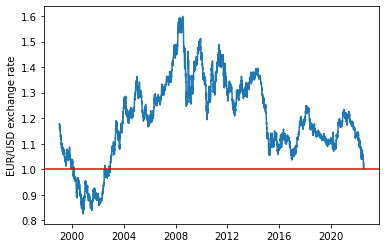

In [7]:
import matplotlib.pyplot as plt
plt.plot(eur_pricing_pd["date"], eur_pricing_pd["eur_usd_rate"])
plt.axhline(y=1, color='r', linestyle='-') #red line for EUR/USD parity
plt.ylabel('EUR/USD exchange rate')
plt.show()

Probably the most interesting thing is the peak in 2008 and hten the continuous decrease. Some economists say that until 2008, the euro was a strong candidate disputing the position of global currency of the dollar, but in the debt crisis of 2008-2012, the ECB made clear that they would what ever it takes to avoid default of European countries, and this means purchasing low-quality assets like bonds of Greece or Spain. In that moment, the economy agents decreased their expectations about the Euro.

Now, we are going to create a new column with the eur pricing of the previous day. We have to do this right here before merging with the sentiment data, because here have continous data, one day per row without gaps, so we can easily calculate the eur pricing of the exact previous day.

In [8]:
#create a pd series with just NaN
import numpy as np
nan_series = pd.Series(np.NaN)
nan_series

0   NaN
dtype: float64

In [9]:
#select all eur values except the last one
eur_pricing_no_last = eur_pricing_pd["eur_usd_rate"].iloc[0:-1]
eur_pricing_no_last

0       1.1789
1       1.1790
2       1.1743
3       1.1632
4       1.1659
         ...  
6024    1.0042
6025    1.0067
6026    1.0005
6027    1.0059
6028    1.0131
Name: eur_usd_rate, Length: 6029, dtype: float64

In [10]:
#to the NaN series, add the eur prices except the last one
previous_pricing = nan_series.append(eur_pricing_no_last)

#reset the index
previous_pricing = previous_pricing.reset_index(drop=True)
previous_pricing

0          NaN
1       1.1789
2       1.1790
3       1.1743
4       1.1632
         ...  
6025    1.0042
6026    1.0067
6027    1.0005
6028    1.0059
6029    1.0131
Length: 6030, dtype: float64

In [11]:
#save
eur_pricing_pd["previous_eur_pricing"] = previous_pricing
    #reset the index in the new variable
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing
0,1999-01-04,1.1789,NaN
1,1999-01-05,1.1790,1.1789
2,1999-01-06,1.1743,1.1790
3,1999-01-07,1.1632,1.1743
4,1999-01-08,1.1659,1.1632
...,...,...,...
6025,2022-07-13,1.0067,1.0042
6026,2022-07-14,1.0005,1.0067
6027,2022-07-15,1.0059,1.0005
6028,2022-07-18,1.0131,1.0059


In [12]:
#check that for each row, the value in "previous_eur_pricing" is equal to "eur_usd_rate" of the previous row
check = [] #empty list to save results

#iterate across the pandas df
for index, row in eur_pricing_pd.T.iteritems():
    
    #avoid the first row that obviously has no previous eur value
    if index > 0:
        check.append(row["previous_eur_pricing"] == eur_pricing_pd["eur_usd_rate"].iloc[index-1])

#see that all True
all(check)

True

In [13]:
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing
0,1999-01-04,1.1789,NaN
1,1999-01-05,1.1790,1.1789
2,1999-01-06,1.1743,1.1790
3,1999-01-07,1.1632,1.1743
4,1999-01-08,1.1659,1.1632
...,...,...,...
6025,2022-07-13,1.0067,1.0042
6026,2022-07-14,1.0005,1.0067
6027,2022-07-15,1.0059,1.0005
6028,2022-07-18,1.0131,1.0059


We are going to calculate the percentage of change of EUR/UDS exchange rate respect to the previous day. We are interested in predict if the currency is going to devaluate 5%, 1%....

In [14]:
#calcualte the percentage of change in one day respect to the previous day
eur_pricing_pd["percent_change_pricing"] = ((eur_pricing_pd["eur_usd_rate"] - eur_pricing_pd["previous_eur_pricing"])/eur_pricing_pd["previous_eur_pricing"])*100
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing,percent_change_pricing
0,1999-01-04,1.1789,NaN,NaN
1,1999-01-05,1.1790,1.1789,0.008482
2,1999-01-06,1.1743,1.1790,-0.398643
3,1999-01-07,1.1632,1.1743,-0.945244
4,1999-01-08,1.1659,1.1632,0.232118
...,...,...,...,...
6025,2022-07-13,1.0067,1.0042,0.248954
6026,2022-07-14,1.0005,1.0067,-0.615874
6027,2022-07-15,1.0059,1.0005,0.539730
6028,2022-07-18,1.0131,1.0059,0.715777


In [15]:
#eur_pricing_pd["relative_diff"] = (eur_pricing_pd["eur_usd_rate"] - eur_pricing_pd["previous_eur_pricing"]) / eur_pricing_pd["eur_usd_rate"]
#eur_pricing_pd
    #if you want to predict the pricing of the currency or its change, you cannot use this metric because 
    #already includes the value of EUR in the present day! which is the thing you want to predict. 

We are going to include as predictors the rolling mean of previoes 60, 10 and 5 days. We are interested in checking if twitter is can improve predictions over the medium term tendencies. So then it would be useful for medium term predictions?

In [16]:
eur_pricing_pd["5_days_rolling_mean_pricing"] = eur_pricing_pd["eur_usd_rate"].rolling(5).mean()
eur_pricing_pd["10_days_rolling_mean_pricing"] = eur_pricing_pd["eur_usd_rate"].rolling(10).mean()
eur_pricing_pd["60_days_rolling_mean_pricing"] = eur_pricing_pd["eur_usd_rate"].rolling(60).mean()
eur_pricing_pd["120_days_rolling_mean_pricing"] = eur_pricing_pd["eur_usd_rate"].rolling(120).mean()
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing,percent_change_pricing,5_days_rolling_mean_pricing,10_days_rolling_mean_pricing,60_days_rolling_mean_pricing,120_days_rolling_mean_pricing
0,1999-01-04,1.1789,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-01-05,1.1790,1.1789,0.008482,NaN,NaN,NaN,NaN
2,1999-01-06,1.1743,1.1790,-0.398643,NaN,NaN,NaN,NaN
3,1999-01-07,1.1632,1.1743,-0.945244,NaN,NaN,NaN,NaN
4,1999-01-08,1.1659,1.1632,0.232118,1.17226,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
6025,2022-07-13,1.0067,1.0042,0.248954,1.01100,1.02284,1.053007,1.082417
6026,2022-07-14,1.0005,1.0067,-0.615874,1.00750,1.01902,1.051537,1.081365
6027,2022-07-15,1.0059,1.0005,0.539730,1.00542,1.01536,1.050273,1.080350
6028,2022-07-18,1.0131,1.0059,0.715777,1.00608,1.01212,1.049248,1.079492


In [17]:
eur_pricing_pd["5_days_exp_rolling_mean_pricing"] = eur_pricing_pd["eur_usd_rate"].ewm(span=5, adjust=False).mean()
eur_pricing_pd["10_days_exp_rolling_mean_pricing"] = eur_pricing_pd["eur_usd_rate"].ewm(span=10, adjust=False).mean()
eur_pricing_pd["60_days_exp_rolling_mean_pricing"] = eur_pricing_pd["eur_usd_rate"].ewm(span=60, adjust=False).mean()
eur_pricing_pd["120_days_exp_rolling_mean_pricing"] = eur_pricing_pd["eur_usd_rate"].ewm(span=120, adjust=False).mean()
    #https://www.statology.org/exponential-moving-average-pandas/
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing,percent_change_pricing,5_days_rolling_mean_pricing,10_days_rolling_mean_pricing,60_days_rolling_mean_pricing,120_days_rolling_mean_pricing,5_days_exp_rolling_mean_pricing,10_days_exp_rolling_mean_pricing,60_days_exp_rolling_mean_pricing,120_days_exp_rolling_mean_pricing
0,1999-01-04,1.1789,NaN,NaN,NaN,NaN,NaN,NaN,1.178900,1.178900,1.178900,1.178900
1,1999-01-05,1.1790,1.1789,0.008482,NaN,NaN,NaN,NaN,1.178933,1.178918,1.178903,1.178902
2,1999-01-06,1.1743,1.1790,-0.398643,NaN,NaN,NaN,NaN,1.177389,1.178079,1.178752,1.178826
3,1999-01-07,1.1632,1.1743,-0.945244,NaN,NaN,NaN,NaN,1.172659,1.175373,1.178242,1.178567
4,1999-01-08,1.1659,1.1632,0.232118,1.17226,NaN,NaN,NaN,1.170406,1.173651,1.177838,1.178358
...,...,...,...,...,...,...,...,...,...,...,...,...
6025,2022-07-13,1.0067,1.0042,0.248954,1.01100,1.02284,1.053007,1.082417,1.011741,1.020807,1.054326,1.076699
6026,2022-07-14,1.0005,1.0067,-0.615874,1.00750,1.01902,1.051537,1.081365,1.007994,1.017115,1.052562,1.075439
6027,2022-07-15,1.0059,1.0005,0.539730,1.00542,1.01536,1.050273,1.080350,1.007296,1.015076,1.051032,1.074290
6028,2022-07-18,1.0131,1.0059,0.715777,1.00608,1.01212,1.049248,1.079492,1.009231,1.014717,1.049788,1.073278


In [18]:
#remove first row with NaN
eur_pricing_pd = eur_pricing_pd.dropna()
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing,percent_change_pricing,5_days_rolling_mean_pricing,10_days_rolling_mean_pricing,60_days_rolling_mean_pricing,120_days_rolling_mean_pricing,5_days_exp_rolling_mean_pricing,10_days_exp_rolling_mean_pricing,60_days_exp_rolling_mean_pricing,120_days_exp_rolling_mean_pricing
119,1999-06-18,1.0388,1.0340,0.464217,1.03804,1.04017,1.060603,1.092362,1.038175,1.040002,1.062343,1.087234
120,1999-06-21,1.0339,1.0388,-0.471698,1.03608,1.04040,1.060015,1.091153,1.036750,1.038892,1.061410,1.086353
121,1999-06-22,1.0313,1.0339,-0.251475,1.03450,1.03968,1.059352,1.089922,1.034933,1.037512,1.060423,1.085443
122,1999-06-23,1.0280,1.0313,-0.319984,1.03320,1.03782,1.058582,1.088703,1.032622,1.035782,1.059360,1.084493
123,1999-06-24,1.0321,1.0280,0.398833,1.03282,1.03629,1.057830,1.087611,1.032448,1.035113,1.058466,1.083627
...,...,...,...,...,...,...,...,...,...,...,...,...
6025,2022-07-13,1.0067,1.0042,0.248954,1.01100,1.02284,1.053007,1.082417,1.011741,1.020807,1.054326,1.076699
6026,2022-07-14,1.0005,1.0067,-0.615874,1.00750,1.01902,1.051537,1.081365,1.007994,1.017115,1.052562,1.075439
6027,2022-07-15,1.0059,1.0005,0.539730,1.00542,1.01536,1.050273,1.080350,1.007296,1.015076,1.051032,1.074290
6028,2022-07-18,1.0131,1.0059,0.715777,1.00608,1.01212,1.049248,1.079492,1.009231,1.014717,1.049788,1.073278


## Loading tweet data

We include tweets about the BCE, which is the entity in charge of protecting the value of the euro, but also tweets about debt crisis in Europe, because this can negatively impact the expectations around the euro. Also tweets about the economy of Europe, because this can influence the expectations of economic agents around the Euro. Specially relevant those countries with sovereing debt problems. I have included countries that experienced high interest rates during the 2008 economic crisis (above 6%, e.g., Spain or Greece; [link](https://en.wikipedia.org/wiki/File:Long-term_interest_rates_(eurozone).png)) and countries that currently having a percentage of debt respect GDP above 85.8%, which is the average of the Euro area ([link](https://www.statista.com/statistics/269684/national-debt-in-eu-countries-in-relation-to-gross-domestic-product-gdp/)). This is specially relevant because the BCE not only acts to preserve the value of the euro but to avoid the bankruptcy of the members states, and both goals can be incompatible in certain circumstances (e.g., buy EU debt when at the same time you have to fight against inflation raising the interest rates). It is worth to mention that the Euros can be seen as liabilities that it has respect to those having euros. Of course, today we do not have gold standard, so we cannot go to the ECB ansd ask for an exchange in gold. However, the ECB has a mandate to control the value of the Euro so those with Euros will not lose value, because of this, there is a goal of 2% inflation per year, that is the limit. For example, if for eany reason there is an increase of inflation (e.g., due to high energy prices), the ECB should use its assets to buy Euros and hence remove them from circulation, this would decrease the offer of Euros, and hence increase the value of the currency. But what happens if the ECB has not enough assets to compensate? or he has assets of low quality like for example bonds from European countries with debt problems? The ECB could have difficulties to use gain capitalization through these assets and use it to stabilize Euro's value. The economic agents know this because they can see the balance of the ECB, and they can decide to go away from Euro. This sentiment of the economic agents for the Euro is what I am trying to catch here, using twitter for that.

I am not interested in the impact of the interest rates or exports of European countries. I am interested in the expectations of the economic agents about the Euro. If mane economic agents think and act in the same way, this is going to influence the demand and value of the currenct. For example, selling their euros because they expect a devlauation of the currency in the near future due to low confidence in Europe's economy. I am trying to capture the echoes of these expectations in twitter.

This would be relevant for any componay interested in the prediction of currencies. If the consideration of the sentiment aroung the currency can help to improve predictions, they could do more advantageous trades. For example, for an american company doing business in Europe.

In [ ]:
#read json files about BCE
import pandas as pd
ecb_search = pd.read_json("data/json_files/search_euro_bank_twitter_1999_1_1.json", lines=True)
ecb_hashtag = pd.read_json("data/json_files/hashtag_euro_bank_twitter_1999_1_1.json", lines=True)

In [ ]:
#read json files about debt crisis and European economy
debt_crisis_search = pd.read_json("data/json_files/search_eu_debt_crisis_twitter_1999_1_1.json", lines=True)
eu_economy_search = pd.read_json("data/json_files/search_european_union_economy_twitter_1999_1_1.json", lines=True)

In [ ]:
#read json files about the economy of specific European countries
    #https://en.wikipedia.org/wiki/European_debt_crisis
iceland_economy_search = pd.read_json("data/json_files/search_iceland_economy_twitter_1999_1_1.json", lines=True)
portugal_economy_search = pd.read_json("data/json_files/search_portugal_economy_twitter_1999_1_1.json", lines=True)
italy_economy_search = pd.read_json("data/json_files/search_italy_economy_twitter_1999_1_1.json", lines=True)
ireland_economy_search = pd.read_json("data/json_files/search_ireland_economy_twitter_1999_1_1.json", lines=True)
greece_economy_search = pd.read_json("data/json_files/search_greece_economy_twitter_1999_1_1.json", lines=True)
spain_economy_search = pd.read_json("data/json_files/search_spain_economy_twitter_1999_1_1.json", lines=True)
cyprus_economy_search = pd.read_json("data/json_files/search_cyprus_economy_twitter_1999_1_1.json", lines=True)
slovenia_economy_search = pd.read_json("data/json_files/search_slovenia_economy_twitter_1999_1_1.json", lines=True)
france_economy_search = pd.read_json("data/json_files/search_france_economy_twitter_1999_1_1.json", lines=True)
belgium_economy_search = pd.read_json("data/json_files/search_belgium_economy_twitter_1999_1_1.json", lines=True)
croatia_economy_search = pd.read_json("data/json_files/search_croatia_economy_twitter_1999_1_1.json", lines=True)

We are going to use also tweets about the different presidents of the ECB during their mandate. This can be another proxy of the sentiment around the institution in charge of preserving the value of the Euro. We only consider tweet for the time window they were presidents of the ECB.

In [ ]:
trichet_search = pd.read_json("data/json_files/search_trichet_twitter.json", lines=True)

We are not using tweets about the USD because it is possible that the demand of US dollars increases (e.g., due to fears of recession and the corresponding search for safe heavens as it still has this reputation), but at the same time people can be unsatified with the way FED deals with inflation. The sentiment around USD in twitter would be negative in general, but it its demand can still increases.

In [ ]:
#process json file
    #https://www.kaggle.com/code/prathamsharma123/clean-raw-json-tweets-data/notebook
print(ecb_search.shape)
    #as many rows as tweets
    #as many columns as features in each tweet

In [ ]:
#see features
print(ecb_search.columns)

In [ ]:
#get all columns for the first tweet
print(ecb_search.iloc[0, :])

In [ ]:
#check that the id is unique for each tweet
print(ecb_search["id"].is_unique)
print(ecb_hashtag["id"].is_unique)
print(debt_crisis_search["id"].is_unique)
print(eu_economy_search["id"].is_unique)
print(iceland_economy_search["id"].is_unique)
print(portugal_economy_search["id"].is_unique)
print(italy_economy_search["id"].is_unique)
print(ireland_economy_search["id"].is_unique)
print(greece_economy_search["id"].is_unique)
print(spain_economy_search ["id"].is_unique)
print(cyprus_economy_search["id"].is_unique)
print(slovenia_economy_search["id"].is_unique)
print(france_economy_search["id"].is_unique)
print(belgium_economy_search["id"].is_unique)
print(croatia_economy_search["id"].is_unique)
print(trichet_search["id"].is_unique)

In [ ]:
#bind data.frames of ecb search and ecb hashtag
tweets_df = ecb_hashtag.append([ecb_search, 
                                debt_crisis_search, 
                                eu_economy_search, 
                                iceland_economy_search,
                                portugal_economy_search,
                                italy_economy_search,
                                ireland_economy_search,
                                greece_economy_search,
                                spain_economy_search ,
                                cyprus_economy_search, 
                                slovenia_economy_search, 
                                france_economy_search,
                                belgium_economy_search,
                                croatia_economy_search,
                                trichet_search])
tweets_df[["id", "date", "rawContent"]]

In [ ]:
#reset the indeces to avoid problems when indexing
tweets_df = tweets_df.reset_index(drop=True)
    #use drop drop parameter to avoid the old index being added as a column
tweets_df[["id", "date", "rawContent"]]

In [ ]:
#check we have the expected number of rows
tweets_df.shape[0] == ecb_search.shape[0] + ecb_hashtag.shape[0] + debt_crisis_search.shape[0] + eu_economy_search.shape[0] + spain_economy_search.shape[0] + slovenia_economy_search.shape[0]

In [ ]:
#release space
del([ecb_search, 
     debt_crisis_search, 
     eu_economy_search, 
     iceland_economy_search,
     portugal_economy_search,
     italy_economy_search,
     ireland_economy_search,
     greece_economy_search,
     spain_economy_search ,
     cyprus_economy_search, 
     slovenia_economy_search, 
     france_economy_search,
     belgium_economy_search,
     croatia_economy_search,
     trichet_search])
import gc
gc.collect()

In [ ]:
#check for duplicated IDs
tweets_df["id"].duplicated().any()

In [ ]:
#take a look to one of the duplicated IDs
example_duplicated_id = tweets_df[tweets_df["id"].duplicated()].iloc[2,:].loc["id"] #get the ID

#get the URL for all tweets having the example ID and check if there are identical URLs
tweets_df.loc[tweets_df["id"] == example_duplicated_id, "url"].duplicated().any()
    #tweets with the same ID have the same URL, so they are the same tweet

In [ ]:
#remove tweets with a duplicated id
tweets_df = tweets_df.drop_duplicates(subset=['id'])
tweets_df.shape

In [ ]:
#check languages
import numpy as np
np.unique(tweets_df["lang"])

In [ ]:
#see tweets not in english
sum(tweets_df["lang"] != "en")

In [ ]:
#select only tweets in english
tweets_df_en = tweets_df[tweets_df["lang"] == "en"]
tweets_df_en.shape
    #CHECK IF THE SENTIMENT MODEL USED CAN DEAL WITH OTHER LANGUAGES

In [ ]:
#get the text for all tweets
tweets_df_en.loc[:, "rawContent"].iloc[0:10,]
    #CHECK IF THERE IS ANY DIFFERENCE RESPECT TO renderedContent

## Sentiment analysis of tweets

We will use VADER to perform the sentiment analysis. There are alternatives like TextBlob, but VADER meets well our requeriments
- It is sensitive to both polarity (positive/negative) and intensity (strength) of emotion.
- you get a positive, negative neutral scores and a compound score 
- labelled data not required because it is pre-trained ([link](https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664), [link](https://towardsdatascience.com/sentiment-analysis-of-tweets-167d040f0583))

In [ ]:
#take example tweet
example_tweet = tweets_df_en.loc[10, "rawContent"]

In [ ]:
#VADER can be used from vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#open instance
analyzer = SentimentIntensityAnalyzer()

#example
print(analyzer.polarity_scores(example_tweet))
print(example_tweet)

In [ ]:
#or from nlTK
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#instance
sid = SentimentIntensityAnalyzer()

In [ ]:
#we get the exact same result
print(sid.polarity_scores(example_tweet))
print(analyzer.polarity_scores(example_tweet))

In [ ]:
#define function to clean the text
import re
def clean_tweet(tweet):
    '''
    Utility function to clean tweet text by removing links, special characters
    using simple regex statements.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet).split())

##CHECK REGULAR EXPRESSIONS

We are going to use the negative sentiment, not the compound (negative-positive-neutral) sentiment. I think that when things are going well (i.e., no inflation) people tend to think that ECB is just doing its job, or that things are going well **despite** the ECB printing money. However, when things go wrong, they all look at the central bank considering it the main cause of the lose of value of the currency, given it is its main mandate, protect the value of its currency. This is specially relevant in the European Union, where different countries with different economies and interests are included, so for example, ensuring the value of the currency by increase interest rate could make things more difficult for European countries with high debts.

WE ARE TO USE COMPOUND! BETTER!

In [ ]:
#define function to be applied per row
def sentiment_per_row(row):
    
    #get the text of the tweet
    tweet_content = row["rawContent"]
    
    #clean
    tweet_cleaned = clean_tweet(tweet_content)
    
    #get the negative sentiment
    sentiment = analyzer.polarity_scores(tweet_cleaned)["neu"]

    #return
    return sentiment

In [ ]:
#apply the function per row and save as a new column
tweets_df_en["neg_sentiment"] = tweets_df_en.apply(sentiment_per_row, axis=1)
    #https://www.geeksforgeeks.org/apply-function-to-every-row-in-a-pandas-dataframe/
    
#CHECK WARNING

In [ ]:
#get the date and sentiment
sentiment_results_df = tweets_df_en[["date", "neg_sentiment"]]
sentiment_results_df

In [ ]:
#leave only year, month and day
sentiment_results_df["date"] = pd.to_datetime(sentiment_results_df["date"].dt.strftime('%Y-%m-%d'))
    #https://stackoverflow.com/questions/38067704/how-to-change-the-datetime-format-in-pandas
    #https://stackoverflow.com/questions/20689288/converting-pandas-columns-to-datetime64-including-missing-values
sentiment_results_df

#CHECK WARNING

In [ ]:
#check we have rows ordered in chronologicla order
sentiment_results_df.equals(sentiment_results_df.sort_index())

In [ ]:
operation="max"
string_evaluate = 'sentiment_results_df.groupby("date")["neg_sentiment"].' + operation + '().to_frame()'
string_evaluate

Now let's calculate several metrics for the sentiment of each day and save them in list of data.frames. Before calculating all metrics, let's take a quick look to .std in pandas

In [ ]:
#get the most frequent value
from statistics import mode
mode([1,2,3,1,1])

In [ ]:
#std gives NA for cases with n=1
print(pd.DataFrame([1,1]).std()) #std = 0
print(pd.DataFrame([1,2]).std()) #std = 0.7
print(pd.DataFrame([1]).std()) #std = NaN

This is solved using ddof=0. ddof is Delta Degrees of Freedom. The divisor used in calculations is N - ddof, where N represents the number of elements


In [ ]:
print(pd.DataFrame([1,1]).std(ddof=0)) #std = 0
print(pd.DataFrame([1,2]).std(ddof=0)) #std = 0.7
print(pd.DataFrame([1]).std(ddof=0)) #std = NaN

We get the same results with np.std and .std(ddof=0)

In [ ]:
print(np.std([1,1])) #std = 0
print(np.std([1,2])) #std = 0.7
print(np.std([1])) #std = NaN

In [ ]:
np.max(np.unique(sentiment_results_df["date"]))

In [ ]:
idx = pd.date_range(np.min(np.unique(sentiment_results_df["date"])), np.max(np.unique(sentiment_results_df["date"])))
sentiment_results_df.groupby("date")["neg_sentiment"].mean().reindex(idx, fill_value=np.NaN)


In [ ]:
sentiment_results_df.groupby("date")["neg_sentiment"].mean().shift(2)

We can also calculate operations between quartiles, like the interquartile range: Q3-Q1

In [ ]:
sentiment_results_df.groupby("date")["neg_sentiment"].apply(lambda a: (np.percentile(a, 75) - np.percentile(a, 25)))

In [ ]:
sentiment_results_df.groupby("date")["neg_sentiment"].apply(lambda a: np.percentile(a, 75))

We can see how the IQR is similar to Q3, this is caused because Q1 tends to be around zero.

In [ ]:
sentiment_results_df.groupby("date")["neg_sentiment"].apply(lambda a: np.percentile(a, 25)).describe()

In [ ]:
#CALCULATE THE MOVING AVERATE OF PREVIOUS SENTIMENT
#https://stackoverflow.com/questions/65929683/calculate-a-rolling-median-on-a-dataframe-that-has-a-non-unique-date-index

In [ ]:
df_per_date = sentiment_results_df.groupby("date")["neg_sentiment"].apply(lambda a: a.values)
df_per_date[0:10]

In [ ]:
check_moving_average = [window for window in df_per_date.rolling(5)]
check_moving_average[0:7]

In [ ]:
check_moving_average[5].explode()

In [ ]:
np.mean(check_moving_average[5].explode())

In [ ]:
df_per_date.index

Given we have many tweets per day (see count below), we can calculate different summary statistics per day. In this way, we can reduce the impact of "trash" in our data. We will deal later with the increased risk of overfitting due to many predictors.

In [ ]:
nan_series = pd.Series(np.repeat(np.nan, 10))
nan_series.append(pd.Series([1,2,3]))

In [ ]:
nan_series = pd.Series(np.repeat(np.nan, 1))
nan_series.append(sentiment_results_df["neg_sentiment"].iloc[0:-1])

In [ ]:
np.append(np.repeat(np.nan, 1), sentiment_results_df["neg_sentiment"].iloc[0:-1].values)

In [ ]:
#open a list of df adding first the EUR pricing
list_data_frames = [eur_pricing_pd]

#define a function to do a given operation grouping by date
def groupby_calcs(operation, metric_name, args=""):
        
    #get the string with the operation name
    string_evaluate = 'sentiment_results_df.groupby("date")["neg_sentiment"].' + operation + '(' + args + ').to_frame()'
        #do operations for the sentiment of each day and then convert to df

    data_frame = eval(string_evaluate)
    idx = pd.date_range(np.min(np.unique(sentiment_results_df["date"])), np.max(np.unique(sentiment_results_df["date"])))
    data_frame = data_frame.reindex(idx, fill_value=np.NaN)
        #https://stackoverflow.com/questions/15610805/accessing-row-from-previous-day-in-pandas-dataframe-with-apply
    data_frame['neg_sentiment'] = data_frame['neg_sentiment'].shift(1)
        #https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
    #data_frame["date"] = data_frame.index
    #data_frame = data_frame.rename(columns={'date': 'index', 'neg_sentiment': 'neg_sentiment_raw'})
    #data_frame["neg_sentiment"] = np.append(np.repeat(np.nan, 2), data_frame["neg_sentiment_raw"].iloc[0:-2].values)
    #data_frame = data_frame.drop(["neg_sentiment_raw"], inplace=False, axis=1)
            #THIS GETS THE SENTIMENT OF THE PREVIOUS ROW, WHICH CNA BE THE PREVIOUS DAY OR NOT!
            #INTENTAR PREVIOUS DAY EXACTLY BY DATE? AND IF NTO NAN?
            #check density of tweets, how many days we do not have tweets?
            #do it with the previos 10 days, twitter can help to predict 10-30 days ahead?
        
    #reset the index
    data_frame = data_frame.reset_index(level=0)
        #set the index (date) as column 
  
    #change the column name for sentiment
    data_frame = data_frame.rename(columns={'index': 'date', 'neg_sentiment': metric_name + '_neg_sent'})

    #append the df to the list
    list_data_frames.append(data_frame)

#define a list of operations to do
metrics_sentiment = ["quantile_0.1",
                     "quantile_0.25",
                     "quantile_0.35",
                     "quantile_0.50",
                     "quantile_0.65",
                     "quantile_0.75",
                     "quantile_0.9",
                     "mean",
                     "sum",
                     "count", 
                         #this can be useful to control for averages with low number of tweets
                         #but also to consider how much people is talking about europes economy
                     "std"]

#apply each operation
for metric in metrics_sentiment:
    
    #for std
    if metric == "std":
        #use ddof=0 to get zero for cases with 1 tweet per day (see above)
        groupby_calcs(operation=metric, metric_name=metric, args='ddof=0')
    elif "quantile" in metric: #if quantile
        #get the operation name and the quantile number
        operation_name = metric.split("_")[0]
        quantile_number = metric.split("_")[1]
        groupby_calcs(operation=operation_name, metric_name=metric, args=quantile_number) 
    elif "previous_sentiment" in metric:
        operation_name = "apply"
        args = "lambda a: a.values"
        groupby_calcs(operation=operation_name, metric_name=metric, args=args)   
    else: 
        groupby_calcs(operation=metric, metric_name=metric) 

        
#check we have the correct number of dfs in the list
len(list_data_frames) == len(metrics_sentiment)+1

In [ ]:
list_data_frames[1]

In [ ]:
#CHECKK THE FIRST 5 DAYS HAVE VALUE!!!! INCLUDES THE CURRENT DAY!!
#this has into account rows? or actual dates?

# drop NAs and group by date into lists of values
df_per_date = sentiment_results_df.groupby("date")["neg_sentiment"].apply(lambda a: a.values)

idx = pd.date_range(np.min(np.unique(sentiment_results_df["date"])), np.max(np.unique(sentiment_results_df["date"])))
df_per_date = df_per_date.reindex(idx, fill_value=np.NaN)


# compute medians across windows ('sum' concatenates multiple lists into one list)
medians = [np.median(window.explode()) for window in df_per_date.rolling(5)]
    #https://stackoverflow.com/questions/30885005/pandas-series-of-lists-to-one-series

# result
medians = pd.DataFrame({"date":df_per_date.index, "moving":medians})
medians
    #https://stackoverflow.com/questions/65929683/calculate-a-rolling-median-on-a-dataframe-that-has-a-non-unique-date-index


In [ ]:
np.quantile([1,2], q=0.5)
np.median([1,2])
np.std([1])

In [ ]:
#define a function to do a given operation grouping by date
def groupby_calcs_moving(operation, metric_name, args="", days=5):
        
    #get the string with the operation name
    df_per_date = sentiment_results_df.groupby("date")["neg_sentiment"].apply(lambda a: a.values)
    
    idx = pd.date_range(np.min(np.unique(sentiment_results_df["date"])), np.max(np.unique(sentiment_results_df["date"])))
    df_per_date = df_per_date.reindex(idx, fill_value=np.NaN)
        #CHECK THIS
    
    if "quantile" in operation:
        string_evaluate_1 = '[np.'+operation+'(window.explode(), q='+args+') for window in df_per_date.rolling('+str(days)+')]'
    elif operation == "len":
        string_evaluate_1 = '['+operation+'(window.explode()) for window in df_per_date.rolling('+str(days)+')]'
    else:
        string_evaluate_1 = '[np.'+operation+'(window.explode()) for window in df_per_date.rolling('+str(days)+')]'

    medians = eval(string_evaluate_1)
    
    data_frame = pd.DataFrame({"date":df_per_date.index, "neg_sentiment":medians})
        
    #change the column name for sentiment
    data_frame = data_frame.rename(columns={'neg_sentiment': metric_name + '_days_moving_neg_sent'})

    #append the df to the list
    list_data_frames.append(data_frame)

#define a list of operations to do
metrics_sentiment_moving = []
for day in [10, 30, 60, 120, 240, 360]:
    metrics_sentiment_moving = metrics_sentiment_moving + [metric + "_" + str(day) for metric in metrics_sentiment]

#apply each operation
for metric in metrics_sentiment_moving:
    
    days = metric.split("_")[-1]
    operation_name = metric.split("_")[0]

    #for std
    if "quantile" in metric: #if quantile
        #get the operation name and the quantile number
        quantile_number = metric.split("_")[1]
        groupby_calcs_moving(operation=operation_name, metric_name=metric, args=quantile_number, days=days) 
    elif "count" in metric:
        groupby_calcs_moving(operation='len', metric_name=metric, days=days) 
    else:
        groupby_calcs_moving(operation=operation_name, metric_name=metric, days=days) 

        
#check we have the correct number of dfs in the list
len(list_data_frames) == (len(metrics_sentiment) + len(metrics_sentiment_moving))+1

In [ ]:
list_data_frames

In [ ]:
##merge all data.frames
from functools import reduce

#merge them using reduce
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['date'], how='inner'), list_data_frames)
    #leave only those rows having date in the datasets of currency value and sentiment
    #https://stackoverflow.com/questions/44327999/python-pandas-merge-multiple-dataframes
df_merged
    #note that here the previous eur pricing can be different than the eur pricing of the previous row
    #because when merging we lose days without tweet sentiment, so there is no longer continuous days

In [ ]:
df_merged = df_merged.dropna()
df_merged

In [ ]:
#check that all days with just 1 tweet have std=0
#np.unique(df_merged[df_merged["count_neg_sent"] == 1]["std_neg_sent"]) == 0

In [ ]:
'''
##plot the metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#for each metric
for metric in metrics_sentiment:
    
    #open a plot with two panels
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))

    #plot scatter against date and eur pricing
    ax1.scatter(x=df_merged["date"], y=df_merged[metric + "_neg_sent"], s=0.5)
    ax2.scatter(x=df_merged["percent_change_pricing"], y=df_merged[metric + "_neg_sent"], s=0.5)
    
    #set ylabel
    ax1.set_ylabel(metric + " negative sentiment")
    ax1.set_xlabel("Year")
    ax2.set_ylabel(metric + " negative sentiment")
    ax2.set_xlabel("Percent change in EUR/USD exchange rate")
    
    #close
    plt.show()
'''

Mean shows that low currency values tend to be associated with high negative sentiment. As the value increase, there is more variation. With more negative but specially much more less negative days. This is even clearer for max. The main difference is that high currency values are associated with a lot of 0 negative days.

It seems that once economic problems arise, then worries extend across economic agents and hence twitter, making less likely to have positive/neutral tweets.

In [ ]:
#save the final data.frame with all metrics and eur pricing
df_merged.to_csv("results/sentiment_ecb_pricing.csv.gz", compression="gzip", index=False)
#df_merged = pd.read_csv("results/sentiment_ecb_pricing.csv.gz", compression="gzip")

In [ ]:
#save the final data.frame with all metrics and eur pricing
df_merged.to_csv("results/sentiment_ecb_pricing.csv.gz", compression="gzip", index=False)
#df_merged = pd.read_csv("results/sentiment_ecb_pricing.csv.gz", compression="gzip")